In [1]:
# downloading of useful libraries
import pandas as pd
import numpy as np
import spacy
import plotly.express as px

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import DBSCAN
from sklearn.decomposition import TruncatedSVD
from sklearn.neighbors import NearestNeighbors # used to find the nearest neighbors of a given point in a multidimensional space

import wordcloud
import matplotlib.pyplot as plt

In [2]:
# downloading of the dataset from a csv file
dataset = pd.read_csv("sample-data.csv")

# overview of the dataset
dataset.head()

id                                        description
0   1  Active classic boxers - There's a reason why o...
1   2  Active sport boxer briefs - Skinning up Glory ...
2   3  Active sport briefs - These superbreathable no...
3   4  Alpine guide pants - Skin in, climb ice, switc...
4   5  Alpine wind jkt - On high ridges, steep ice an...

In [3]:
# let's have a look at the size of the dataset
print("The dataset has {} columns and {} rows.".format(dataset.shape[1], dataset.shape[0]))

The dataset has 2 columns and 500 rows.


We can observe that one column is an id number which isn't very helpful. Only the second one (description) is important.

#### 1 - Data preparation

In [4]:
# creation of a new column with text cleaned.
# first we put all the character in lower case, and in case of we replace na by empty cell
dataset["description_clean"] = dataset["description"].fillna("").apply(lambda x : x.lower())

In [5]:
# we replace html tag by a space, using a regular expression and the function replace()
# r"<.*?>": This regular expression matches any string that starts with <, followed by any characters (.*), and ends with >. In other words, it matches HTML tags
# the ? makes the * quantifier match as little text as possible
# in case of, fills any missing (NaN) values in the "description_clean" column with an empty string ("")
dataset["description_clean"] = dataset["description_clean"].fillna("").replace(r"<.*?>", " ", regex=True)

In [6]:
# we replace non alphanumerical character by a space, using a regular expression and the function replace()
# r"[^A-Za-z0-9]" : This regular expression matches any sequence of characters that are not letters (both uppercase and lowercase) or digits
# ^ at the beginning negates the set, meaning it matches any character that is not in the specified range
# in case of, fills any missing (NaN) values in the "description_clean" column with an empty string ("")
dataset["description_clean"] = dataset["description_clean"].fillna("").replace(r"[^A-Za-z0-9]+"," ", regex=True)

In [7]:
# downloading of the dictionnary in english and stop words
# en_core_web_sm is a small English pipeline trained on written web text (blogs, news, comments), that includes vocabulary, syntax and entities (definition from spacy.io)
import en_core_web_sm
from spacy.lang.en.stop_words import STOP_WORDS
nlp = en_core_web_sm.load()

In [8]:
# creation of a new column with text tokenized from text cleaned
# in case of, fills any missing (NaN) values in the "description_clean" column with an empty string ("")
dataset["description_tokenized"] = dataset["description_clean"].fillna("").apply(lambda x: nlp(x))

In [9]:
# lemmatization of the column with the text tokenized by removing stop words
# Lemmatization is a technique used to reduce inflected words to their root word (source datacamp.com)
dataset["description_tokenized"] = dataset["description_tokenized"].fillna("").apply(lambda x: [token.lemma_ for token in x if token.text not in STOP_WORDS])

In [10]:
# let's have a look at the job
dataset.head()

id                                        description  \
0   1  Active classic boxers - There's a reason why o...   
1   2  Active sport boxer briefs - Skinning up Glory ...   
2   3  Active sport briefs - These superbreathable no...   
3   4  Alpine guide pants - Skin in, climb ice, switc...   
4   5  Alpine wind jkt - On high ridges, steep ice an...   

                                   description_clean  \
0  active classic boxers there s a reason why our...   
1  active sport boxer briefs skinning up glory re...   
2  active sport briefs these superbreathable no f...   
3  alpine guide pants skin in climb ice switch to...   
4  alpine wind jkt on high ridges steep ice and a...   

                               description_tokenized  
0  [active, classic, boxer, s, reason, boxer, cul...  
1  [active, sport, boxer, brief, skin, glory, req...  
2  [active, sport, brief, superbreathable, fly, b...  
3  [alpine, guide, pant, skin, climb, ice, switch...  
4  [alpine, wind, jkt, high, ridge, steep, ice, a...

In [11]:
# join all the words in the same column from text tokenized, with space between words, in order to have again a sentence
dataset["description_tokenized"] = dataset["description_tokenized"].apply(lambda x : " ".join(x))

In [12]:
# let's have a look at the job
dataset.head()

id                                        description  \
0   1  Active classic boxers - There's a reason why o...   
1   2  Active sport boxer briefs - Skinning up Glory ...   
2   3  Active sport briefs - These superbreathable no...   
3   4  Alpine guide pants - Skin in, climb ice, switc...   
4   5  Alpine wind jkt - On high ridges, steep ice an...   

                                   description_clean  \
0  active classic boxers there s a reason why our...   
1  active sport boxer briefs skinning up glory re...   
2  active sport briefs these superbreathable no f...   
3  alpine guide pants skin in climb ice switch to...   
4  alpine wind jkt on high ridges steep ice and a...   

                               description_tokenized  
0  active classic boxer s reason boxer cult favor...  
1  active sport boxer brief skin glory require mo...  
2  active sport brief superbreathable fly brief m...  
3  alpine guide pant skin climb ice switch rock t...  
4  alpine wind jkt high ridge steep ice alpine ja...

#### 2 - Data preprocessing

In [13]:
# instanciate TfidVecorizer with stop words in english
vectorizer = TfidfVectorizer(stop_words="english")

In [14]:
# Use of TFid on the column tokenized and affect values to X
# our vectorizer will transform the column "description_tokenized" in a TF-IDF matrix (format sparse matrix)
X=vectorizer.fit_transform(dataset["description_tokenized"])

In [15]:
X

<500x3833 sparse matrix of type '<class 'numpy.float64'>'
	with 34813 stored elements in Compressed Sparse Row format>

In [16]:
# transform sparse matrix X into an array, and affect it to dense
dense = X.toarray()

# visualize the array
dense

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [17]:
# dictionary with the list of the vocabulary and its index
vectorizer.vocabulary_

{'active': 319,
 'classic': 801,
 'boxer': 628,
 'reason': 2676,
 'cult': 1014,
 'favorite': 1387,
 'cool': 939,
 'especially': 1315,
 'sticky': 3192,
 'situation': 3017,
 'quick': 2633,
 'dry': 1198,
 'lightweight': 2007,
 'underwear': 3574,
 'minimal': 2179,
 'space': 3116,
 'travel': 3491,
 'pack': 2388,
 'expose': 1348,
 'brush': 658,
 'waistband': 3689,
 'offer': 2327,
 'skin': 3028,
 'softness': 3097,
 'panel': 2407,
 'construction': 916,
 'traditional': 3475,
 'fit': 1433,
 'functional': 1536,
 'fly': 1476,
 'oz': 2385,
 '100': 3,
 'recycle': 2685,
 'polyester': 2530,
 'moisture': 2204,
 'wicke': 3764,
 'performance': 2460,
 'inseam': 1839,
 'size': 3018,
 'recyclable': 2684,
 'common': 872,
 'thread': 3411,
 'program': 2586,
 'silky': 2996,
 'capilene': 712,
 'fabric': 1365,
 'ultralight': 3554,
 'breathable': 636,
 'elastic': 1247,
 'comfort': 863,
 'gladiodor': 1579,
 'natural': 2254,
 'odor': 2326,
 'control': 929,
 'garment': 1551,
 'weight': 3741,
 '99': 294,
 'mexico': 21

In [18]:
# matrix of vocabulary
# in column's name we have the vocabulary, and each column represents the vocabulary expresses in a number of variables (rows)
# we set the columns of the DataFrame matrix using a list comprehension with the feature names obtained from the TF-IDF vectorizer
# in rows we have the dense matrix representing the TF-IDF scores for each term in each document
matrix = pd.DataFrame(dense, columns=[x for x in vectorizer.get_feature_names_out()])
matrix.head()

000   03        10       100  1000  1021  1027  103  1038  1055  ...  yvon  \
0  0.0  0.0  0.000000  0.075858   0.0   0.0   0.0  0.0   0.0   0.0  ...   0.0   
1  0.0  0.0  0.000000  0.000000   0.0   0.0   0.0  0.0   0.0   0.0  ...   0.0   
2  0.0  0.0  0.000000  0.000000   0.0   0.0   0.0  0.0   0.0   0.0  ...   0.0   
3  0.0  0.0  0.000000  0.000000   0.0   0.0   0.0  0.0   0.0   0.0  ...   0.0   
4  0.0  0.0  0.049334  0.048673   0.0   0.0   0.0  0.0   0.0   0.0  ...   0.0   

   zest  zinger  zip  zipped    zipper  zippered  zipping  zips  zone  
0   0.0     0.0  0.0     0.0  0.000000  0.000000      0.0   0.0   0.0  
1   0.0     0.0  0.0     0.0  0.000000  0.000000      0.0   0.0   0.0  
2   0.0     0.0  0.0     0.0  0.000000  0.000000      0.0   0.0   0.0  
3   0.0     0.0  0.0     0.0  0.049926  0.264379      0.0   0.0   0.0  
4   0.0     0.0  0.0     0.0  0.149844  0.000000      0.0   0.0   0.0  

[5 rows x 3833 columns]

In [19]:
# size of this matrix
print("the matrix has {} different words, expressed in {} dimensions".format(matrix.shape[1], matrix.shape[0]))

the matrix has 3833 different words, expressed in 500 dimensions


### 3- DBSCAN

DBSCAN means Density-Based Spatial Clustering of Applications with Noise.

It is a clustering algorithm used in machine learning and data analysis to group together data points that are close to each other in a high-dimensional space.

Unlike some other clustering algorithms, DBSCAN does not require the number of clusters to be specified before.

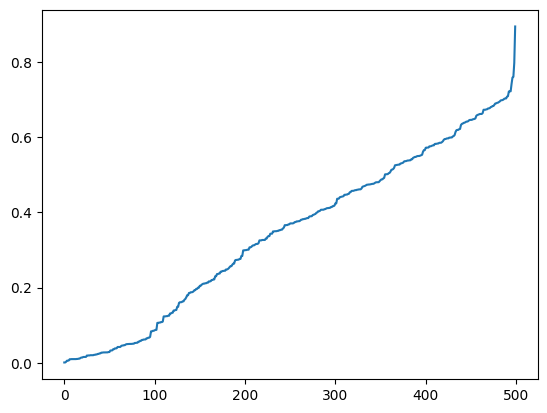

In [49]:
# this code was adapted from explications found on stackoverflow. I apologize but i forgot to copy the link when i found it and i failed to find it a second time.

neigh = NearestNeighbors(n_neighbors=5, # we want to find the 5 nearest neighbors for each point
                         metric="cosine") # specifies the distance metric to be used

nbrs = neigh.fit(matrix) # fits the NearestNeighbors model to the given matrix. This essentially precomputes the neighbors for the provided data.

distances, indices = nbrs.kneighbors(matrix) # The distances variable will contain the distances to the neighbors, and the indices variable will contain the indices of those neighbors.

distances = np.sort(distances, axis=0) # sorts the distances along the columns (axis=0) so that for each point, the distances to its nearest neighbors are in ascending order.

distances = distances[:,1] # extracts the distances to the second nearest neighbors (since the nearest neighbor is the point itself, which always has a distance of 0)

plt.plot(distances) # creates a simple line plot to visualize the distances to the second nearest neighbors for each point. This plot gives insights into the structure and density of the data.

The graph above shows the number of neighbors found (x), according to the distance (y).
If we want to avoid an important quantity of noise with dbscan, we should set a distance that allow us to maximise the number of neighbors.
In our case, a distance at around 0.7 looks great.

In [80]:
# instanciate DBSCAN with values for the main parameters, and train from the matrix
# eps = The maximum distance between two samples for one to be considered as in the neighborhood of the other.
# min_samples = This parameter determines the minimum number of data points required to form a dense region (core point)
# metric = The metric to use when calculating distance between instances in a feature array.
db=DBSCAN(eps=0.7, min_samples=5, metric="cosine")
db.fit(matrix)

DBSCAN(eps=0.7, metric='cosine')

In [51]:
# display an array with unique values of labels from our model
# in this case, we have the number of clusters given by our model
# -1 are noisy samples or outliers
np.unique(db.labels_)

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12],
      dtype=int64)

In [52]:
# transfrom array in pandas series
value = pd.Series(np.unique(db.labels_))
# shows the results
value

0     -1
1      0
2      1
3      2
4      3
5      4
6      5
7      6
8      7
9      8
10     9
11    10
12    11
13    12
dtype: int64

In [53]:
# shows for each words the cluster number in which it is affected
db.labels_

array([ 0,  0, -1,  1,  1,  1,  2,  3,  1, -1, -1,  1, 10,  6,  1,  1, -1,
        0,  0,  0,  0,  0,  0,  0,  0,  4,  1,  1,  1, -1,  2,  1,  1,  1,
        1,  4,  1,  6, -1,  1,  4,  2,  1,  1,  1,  1,  1,  5, -1, -1,  1,
        1,  2,  2,  2,  4,  0,  4,  1,  0,  0, -1,  4,  4,  4,  6,  1,  4,
        5,  1,  4,  4,  4, 10,  7,  1,  7, -1,  8,  8,  8,  0,  2,  2,  1,
        1,  8,  8,  8,  8,  1,  1,  2,  2,  4,  1,  1,  4, -1,  1, -1,  4,
        4,  2,  0,  0,  1,  1,  1,  1, -1, -1,  9,  9,  1,  4,  0,  1,  1,
        1, -1, -1,  1,  4,  1,  1,  1,  1,  1, -1,  2,  1,  2, -1, 10,  9,
       -1,  4,  4, -1,  1, -1,  1,  4, -1,  1,  1,  8, 10, 11,  4,  4, 11,
       11, -1,  3,  1, -1,  1,  6,  6,  1, -1, -1, -1,  6,  4,  1,  4,  4,
        0,  0,  0,  0,  0,  0,  4,  4,  1,  6, -1, -1,  1,  1,  4,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  7,  0,  1,  6,  1,  8,  8,  8,  8,  1,
       12, -1,  1,  1,  1,  1,  0,  1,  1,  1, -1,  1,  1,  1,  3,  3,  3,
        3,  1,  1, -1,  7

In [54]:
# create a column "cluster" in the original dataframe with the value of the cluster for each sentences
dataset["cluster"] = db.labels_

# overview of the dataframe
dataset.head()

id                                        description  \
0   1  Active classic boxers - There's a reason why o...   
1   2  Active sport boxer briefs - Skinning up Glory ...   
2   3  Active sport briefs - These superbreathable no...   
3   4  Alpine guide pants - Skin in, climb ice, switc...   
4   5  Alpine wind jkt - On high ridges, steep ice an...   

                                   description_clean  \
0  active classic boxers there s a reason why our...   
1  active sport boxer briefs skinning up glory re...   
2  active sport briefs these superbreathable no f...   
3  alpine guide pants skin in climb ice switch to...   
4  alpine wind jkt on high ridges steep ice and a...   

                               description_tokenized  cluster  
0  active classic boxer s reason boxer cult favor...        0  
1  active sport boxer brief skin glory require mo...        0  
2  active sport brief superbreathable fly brief m...       -1  
3  alpine guide pant skin climb ice switch rock t...        1  
4  alpine wind jkt high ridge steep ice alpine ja...        1

In [55]:
# size of each clusters found
for i in value :
    mask = (dataset["cluster"] == i) # create a mask in order to filter our dataset
    sample1 = dataset.loc[mask,"description"] # apply filter on our dataset
    print("cluster {}, number of items : {}".format(i, sample1.shape[0])) #use shape and first number to get the number of value

cluster -1, number of items : 61
cluster 0, number of items : 60
cluster 1, number of items : 189
cluster 2, number of items : 29
cluster 3, number of items : 21
cluster 4, number of items : 58
cluster 5, number of items : 8
cluster 6, number of items : 19
cluster 7, number of items : 7
cluster 8, number of items : 24
cluster 9, number of items : 5
cluster 10, number of items : 8
cluster 11, number of items : 7
cluster 12, number of items : 4


We get 13 clusters, except the one with noise items.

We can see that the number of items considered as outliers, or noises, is not so significant regarding the total number of events (61 on 500 which is a little more thant 10% of our dataset).

We could try to see what are the impacts of changing parameters.

In [60]:
# let's create first a function
def dbscan_model(eps,min_samples,metric) :
    """
    Function to get the soze of each cluster created with DBSCAN according to the parameters given in input
    Args:
        eps (float): maximum distance between two samples for one to be considered as in the neighborhood of the other
        min_samples (integer): minimum number of data points required to form a dense region (core point)
        metric (string): metric to use when calculating distance between instances in a feature array.
    """
    db=DBSCAN(eps=eps, min_samples=min_samples, metric=metric)
    db.fit(matrix)
    dataset["cluster"] = db.labels_
    for i in value :
        mask = (dataset["cluster"] == i)
        sample1 = dataset.loc[mask,"description"]
        print("cluster {}, number of items : {}".format(i, sample1.shape[0]))

In [79]:
# first try by increasing only the number of min_samples
dbscan_model(0.7,7,"cosine")

cluster -1, number of items : 92
cluster 0, number of items : 180
cluster 1, number of items : 27
cluster 2, number of items : 13
cluster 3, number of items : 58
cluster 4, number of items : 57
cluster 5, number of items : 8
cluster 6, number of items : 24
cluster 7, number of items : 8
cluster 8, number of items : 7
cluster 9, number of items : 19
cluster 10, number of items : 7
cluster 11, number of items : 0
cluster 12, number of items : 0


If we increase the size of min_samples, we increase a the number of outliers, and reduce to zero some clusters, which is not a good trend.

In [62]:
# second try by increasing only the distance (eps)
dbscan_model(0.8,5,"cosine")

cluster -1, number of items : 6
cluster 0, number of items : 481
cluster 1, number of items : 8
cluster 2, number of items : 5
cluster 3, number of items : 0
cluster 4, number of items : 0
cluster 5, number of items : 0
cluster 6, number of items : 0
cluster 7, number of items : 0
cluster 8, number of items : 0
cluster 9, number of items : 0
cluster 10, number of items : 0
cluster 11, number of items : 0
cluster 12, number of items : 0


If we increase the maximum distance between two samples, we concentrate values in a few clusters, which is not also a good trend

In [81]:
# after a few tries, the best parameters were this ones :
dbscan_model(0.71,5,"cosine")

cluster -1, number of items : 42
cluster 0, number of items : 64
cluster 1, number of items : 216
cluster 2, number of items : 30
cluster 3, number of items : 21
cluster 4, number of items : 60
cluster 5, number of items : 8
cluster 6, number of items : 7
cluster 7, number of items : 24
cluster 8, number of items : 5
cluster 9, number of items : 8
cluster 10, number of items : 7
cluster 11, number of items : 4
cluster 12, number of items : 4


In [63]:
#let's see if we change the metric, with the same others parameters
dbscan_model(0.7,5,"euclidean")

cluster -1, number of items : 469
cluster 0, number of items : 6
cluster 1, number of items : 13
cluster 2, number of items : 6
cluster 3, number of items : 6
cluster 4, number of items : 0
cluster 5, number of items : 0
cluster 6, number of items : 0
cluster 7, number of items : 0
cluster 8, number of items : 0
cluster 9, number of items : 0
cluster 10, number of items : 0
cluster 11, number of items : 0
cluster 12, number of items : 0


Results aren't good. We will use the NearestNeignbors class to find the best parameters with this metric.

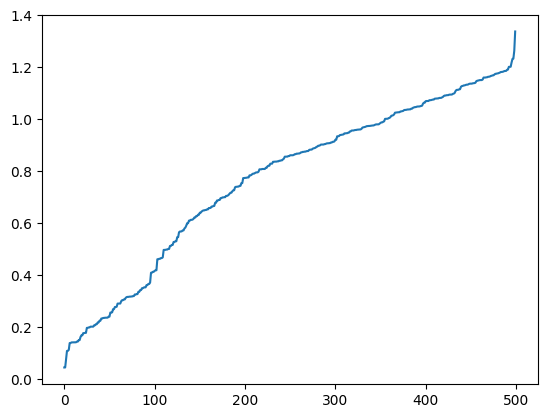

In [64]:
neigh = NearestNeighbors(n_neighbors=5, metric="euclidean")
nbrs = neigh.fit(matrix)
distances, indices = nbrs.kneighbors(matrix)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

In [75]:
# after a few tries, the best parameters were the following ones
dbscan_model(1.19,5,"euclidean")

cluster -1, number of items : 50
cluster 0, number of items : 64
cluster 1, number of items : 192
cluster 2, number of items : 30
cluster 3, number of items : 21
cluster 4, number of items : 20
cluster 5, number of items : 60
cluster 6, number of items : 8
cluster 7, number of items : 7
cluster 8, number of items : 24
cluster 9, number of items : 5
cluster 10, number of items : 8
cluster 11, number of items : 7
cluster 12, number of items : 4


For the rest of our excercice, we will keep a "cosine" metric.

In [82]:
# let's train the model retained
dbscan_model(0.71,5,"cosine")

cluster -1, number of items : 42
cluster 0, number of items : 64
cluster 1, number of items : 216
cluster 2, number of items : 30
cluster 3, number of items : 21
cluster 4, number of items : 60
cluster 5, number of items : 8
cluster 6, number of items : 7
cluster 7, number of items : 24
cluster 8, number of items : 5
cluster 9, number of items : 8
cluster 10, number of items : 7
cluster 11, number of items : 4
cluster 12, number of items : 4


Let's get three samples of articles for each cluster

In [86]:
# let's first get the number of clusters
nb_clusters = len(pd.Series(np.unique(db.labels_)))

# make a loop on the number of clusters, and select a sample of 3 articles if possible
for i in range (-1,nb_clusters-1,1) :
    mask = (dataset["cluster"] == i)
    try : # we include a try/except in order to avoid error if there is no articles
        sample = dataset.loc[mask,"description"]
        print("Samples for cluster {}".format(i))
        print(sample.sample(3))
        print()
    except :
        print("No sample found for class {}".format(i))
    

Samples for cluster -1
416    Micro d-luxe cardigan - A Micro D-Luxe Cardiga...
433    Girl's t-back one piece - A girl's trusted com...
316    Barely everyday bra (b/c) - The flattering Bar...
Name: description, dtype: object

Samples for cluster 0
377    R1 full-zip jkt - It stretches, breathes, wick...
477    L/s sol patrol shirt - Two-week boat trips in ...
18     Cap 1 boxer briefs - On bivy or belay, the for...
Name: description, dtype: object

Samples for cluster 1
186    Inter-continental capris - Inter-Continental C...
403    Hooded monk sweatshirt - The sacred garment of...
145    Twenty-three's board shorts - Stay covered in ...
Name: description, dtype: object

Samples for cluster 2
82     Lw travel duffel - This wanderer's bag is larg...
435    Lightwire - Sometimes you need to leave the of...
430    Mlc burrito - Ever show up at a confab looking...
Name: description, dtype: object

Samples for cluster 3
257    Sport top - The loose, performance fit of the ...
243    Print

In [87]:
# instantiate wordcloud which allows us to visualize words and their importance
wd = wordcloud.WordCloud()

CLUSTER  1


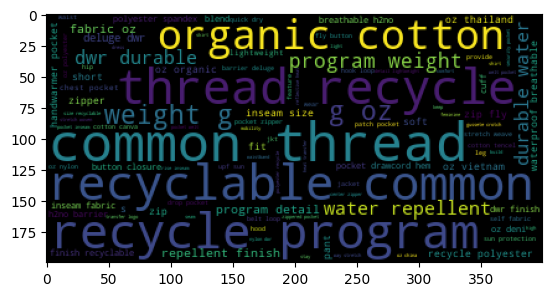

-----------
CLUSTER  0


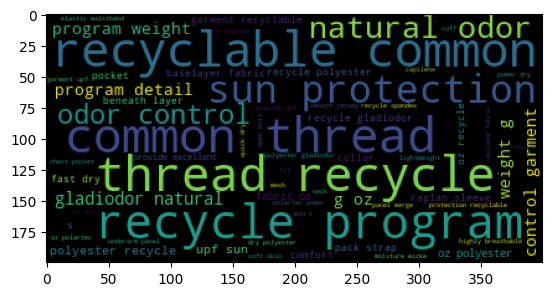

-----------
CLUSTER  4


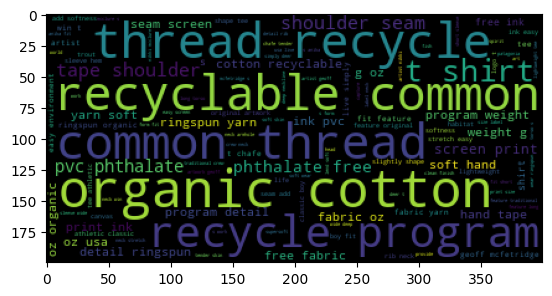

-----------
CLUSTER  -1


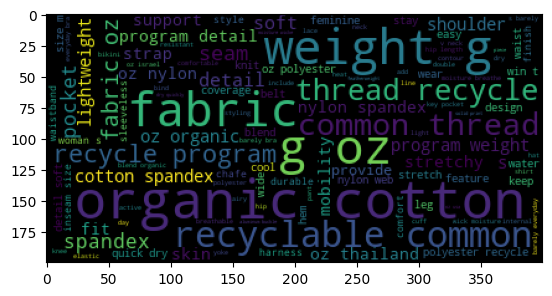

-----------
CLUSTER  2


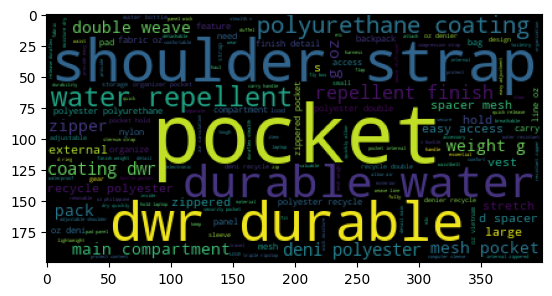

-----------
CLUSTER  7


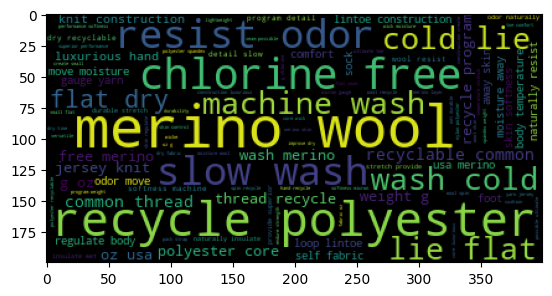

-----------
CLUSTER  3


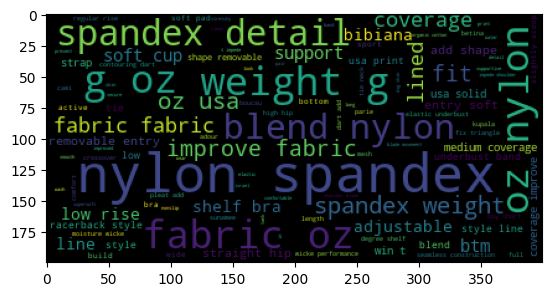

-----------
CLUSTER  9


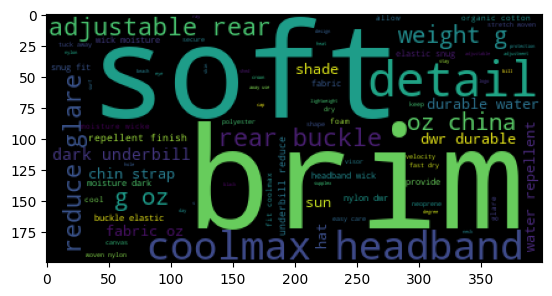

-----------
CLUSTER  5


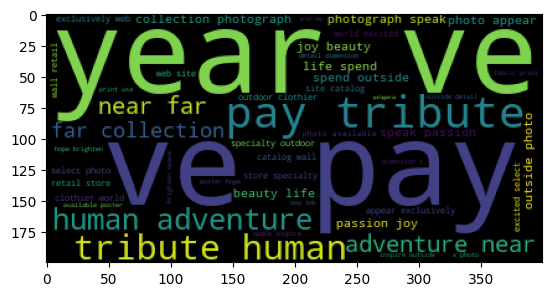

-----------
CLUSTER  6


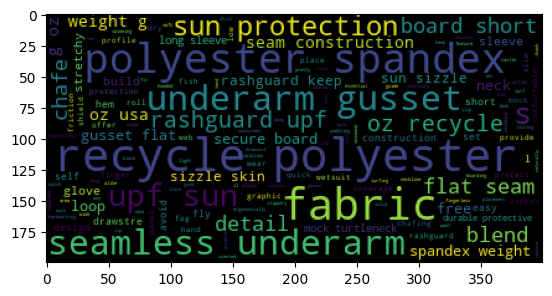

-----------
CLUSTER  10


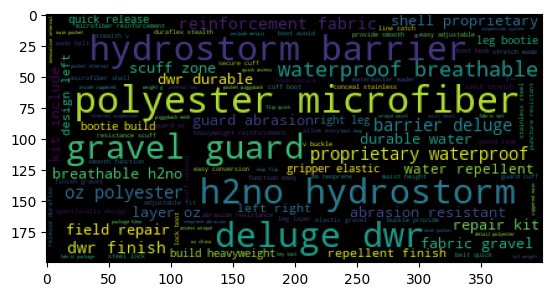

-----------
CLUSTER  8


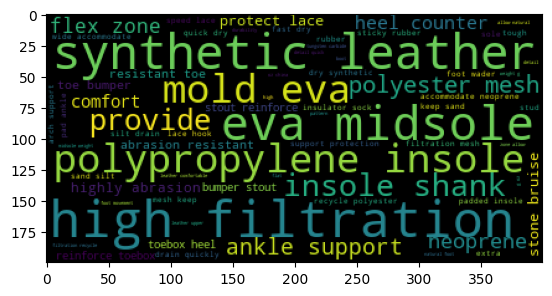

-----------
CLUSTER  12


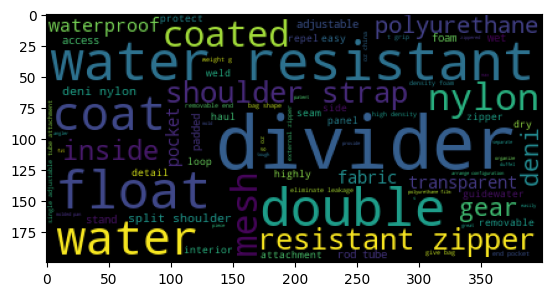

-----------
CLUSTER  11


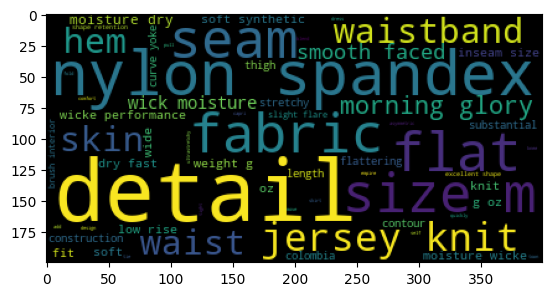

-----------


In [88]:
# visualization of main words (word cloud) for each cluster
for c in dataset["cluster"].value_counts().index : # gives the unique values of the clusters sorted by their importance (number of values)
    print("CLUSTER ", c)
    texts = " ".join(dataset.loc[dataset["cluster"]==c,"description_tokenized"]) # Concatenates the text documents in the current cluster into a single string named texts. It uses the "description_tokenized" column from the DataFrame
    cloud = wd.generate(texts) # generates a word cloud from the concatenated text for the current cluster using generator wordcloud
    plt.imshow(cloud) # displays the generated wordcloud using Matplotlib
    plt.show() # shows the plot
    print("-----------")

In [90]:
def find_similar_items(id_item=1, number=5) :
    """
    function allows to find a number of similar items from a given article (id number) choosen by the user
    Args:
        id_item (integer): number given by the user between 1 and 500 (1 by default)
        number (integer)= number of sentences to find (5 by default)
    """
    # check to ensure that the provided id_item is within the valid range (1 to 500). If it's not within the range, a message is printed, and the function exits
    if int(id_item) > 500 or int(id_item) < 1 :
        print("ref number is out of range, please set a number between 1 and 500")
    else :
        # function retrieves the cluster_id associated with the specified id_item from the dataset
        cluster_id = dataset.loc[dataset["id"]==int(id_item),"cluster"].values[0] # .values pour enlever les index et ne garder que la valeur
        # creates a mask to filter items in the dataset that belong to the same cluster as the specified item
        mask = (dataset["cluster"] == cluster_id)
        #  samples a specified number of sentences (number) from the descriptions of items in the same cluster
        liste = dataset.loc[mask,"description"].sample(number)
        # If no similar items are found, it prints a message. Otherwise, it prints the list of sampled similar items
        if len(liste) == 0 :
            print("No another article found")
        else :
            print(liste)

choice = input("choose an id between 1 and 500:")
find_similar_items(id_item=choice)

238    Yosemite essence t-shirt - Artist Phyllis Shaf...
55     Iceberg t-shirt - The effects of global warmin...
432    Girl's live simply seal t-shirt - Soft-wearing...
470    Baby live simply seal t-shirt - Swim, fish, ha...
469    Baby live simply deer t-shirt - The Live Simpl...
Name: description, dtype: object


### 4 - SVD Model

perform Latent Semantic Analysis (LSA) on a matrix (matrix).

LSA is a technique that applies Singular Value Decomposition (SVD) to a term-document matrix to discover latent topics in a collection of documents.

TruncatedSVD is the scikit-learn implementation of Truncated Singular Value Decomposition, which is a variant of SVD

In [102]:
# Instantiate model with values for main parameters, and fit
# n_components = specifies the number of components (or topics) to retain after decomposition
# n_iter = specifies the number of iterations for the optimization algorithm. A higher number may lead to more accurate results, but it could also increase computation time
svd_model = TruncatedSVD(n_components=10, n_iter=500, random_state=0)

# fit model on the matrix determined before, than transform it into an array where each row corresponds to a document, and each column corresponds to a latent topic
lsa = svd_model.fit_transform(matrix)

In [103]:
# creation of a dataframe with coefficients for each topic, and a column with the tokenized text (documents)
# we set the column's name with a list comprehension
topic_encoded_df = pd.DataFrame(lsa, columns=["topic_{}".format(i+1) for i in range(10)], index = dataset.index)

# we had in our new dataset a column with the tokenized sentences
topic_encoded_df["documents"]=dataset["description_tokenized"]

# overview of the dataframe created
topic_encoded_df

topic_1   topic_2   topic_3   topic_4   topic_5   topic_6   topic_7  \
0    0.278233 -0.045958  0.184359  0.083938 -0.122873 -0.014662 -0.055467   
1    0.277866 -0.060689  0.097423  0.096460 -0.011016  0.106851 -0.061501   
2    0.265909 -0.082200  0.110598  0.027234 -0.017384  0.115961  0.012061   
3    0.382988 -0.252585 -0.115812 -0.139265  0.049480 -0.010041 -0.018968   
4    0.395487 -0.268967 -0.025769 -0.234405 -0.037164 -0.024746  0.050016   
..        ...       ...       ...       ...       ...       ...       ...   
495  0.334433 -0.078282  0.391558  0.070603 -0.261080 -0.039831 -0.037203   
496  0.371022 -0.075686  0.489173 -0.010508 -0.302613 -0.044846  0.002745   
497  0.344310 -0.222932 -0.069260 -0.247970 -0.013447 -0.150549  0.138611   
498  0.330005  0.052317 -0.130341  0.315485  0.025854 -0.139097 -0.117941   
499  0.393826  0.050356 -0.187955  0.348455  0.017231 -0.154037 -0.108315   

      topic_8   topic_9  topic_10  \
0   -0.019216 -0.149581  0.001630   
1   -0.023856 -0.109068 -0.072621   
2    0.057730 -0.058763 -0.012502   
3   -0.053827 -0.052572 -0.152228   
4    0.044135  0.041475 -0.195193   
..        ...       ...       ...   
495 -0.097534 -0.341436  0.033678   
496 -0.003769 -0.241649  0.108678   
497 -0.169114  0.052856  0.039383   
498 -0.004451 -0.085074  0.024806   
499 -0.001082 -0.072342  0.019956   

                                             documents  
0    active classic boxer s reason boxer cult favor...  
1    active sport boxer brief skin glory require mo...  
2    active sport brief superbreathable fly brief m...  
3    alpine guide pant skin climb ice switch rock t...  
4    alpine wind jkt high ridge steep ice alpine ja...  
..                                                 ...  
495  cap 2 bottom cut loose madden crowd search und...  
496  cap 2 crew crew take edge fickle weather clear...  
497  time shell need use morning time umbrella time...  
498  wear cargo short wear cargo short bask glory s...  
499  wear short time simplify wear short prove shor...  

[500 rows x 11 columns]

In [104]:
# creation of a column "class_pred" with the main topic
# we use a list comprehension to affect for each sentence the topic with the highest coefficient
topic_encoded_df["class_pred"] = [np.argmax(topic) for topic in lsa]

# Distribution of the different topics
topic_encoded_df["class_pred"].value_counts()

class_pred
0    277
1     61
2     35
7     27
5     24
9     20
8     19
3     15
4     12
6     10
Name: count, dtype: int64

The first class (value zero) is very important.

In [105]:
# overview of the new dataframe with topics coefficient and class prediction
topic_encoded_df.sample(10)

topic_1   topic_2   topic_3   topic_4   topic_5   topic_6   topic_7  \
214  0.253417  0.003264 -0.082091  0.186085  0.032306  0.067705  0.118636   
174  0.362654 -0.092438  0.420839 -0.012349 -0.298843 -0.085555  0.011050   
454  0.268403 -0.237413 -0.083532 -0.248587  0.146961 -0.042601  0.101955   
470  0.386892  0.557273 -0.041926 -0.210642 -0.000598  0.056720 -0.044423   
256  0.265027 -0.034536  0.016644  0.032584 -0.120067  0.054610 -0.081044   
45   0.364575 -0.175100 -0.074575  0.033836  0.051799  0.069071 -0.082119   
316  0.167087 -0.030597  0.082136  0.055742  0.030220  0.158284  0.132132   
85   0.238037 -0.202653 -0.122044 -0.160960  0.036825 -0.041144  0.054310   
154  0.216751 -0.032102  0.074673  0.044567  0.042401  0.193809  0.045508   
452  0.288959  0.000263 -0.182278  0.211068  0.011693 -0.126758 -0.065517   

      topic_8   topic_9  topic_10  \
214 -0.003199 -0.035238  0.042233   
174 -0.009566 -0.235126  0.080786   
454 -0.217104 -0.044333  0.373218   
470 -0.047196 -0.039290 -0.029457   
256  0.000704  0.282157  0.044667   
45  -0.093770 -0.114327 -0.084208   
316  0.083883  0.007034  0.014527   
85  -0.223461 -0.035448  0.086563   
154 -0.036618 -0.053433 -0.061762   
452  0.007371 -0.034212  0.014002   

                                             documents  class_pred  
214  serenity tight long soft stretchy unrestricted...           0  
174  cap 2 zip neck bugaboo long approach sweaty bl...           2  
454  guidewater wader king build guidewater wader t...           9  
470  baby live simply seal t shirt swim fish haul s...           1  
256  sol patrol shirt ahead bone fishing ride horse...           8  
45   girl s boardie short raise neptune s daughter ...           0  
316  barely everyday bra b c flattering barely ever...           0  
85   m10 pant volatile climate don t rule big adven...           0  
154  active hipster perfect life nomadic perfect un...           0  
452  compound cargo short cargo pocket pull vintage...           0

CLUSTER  0


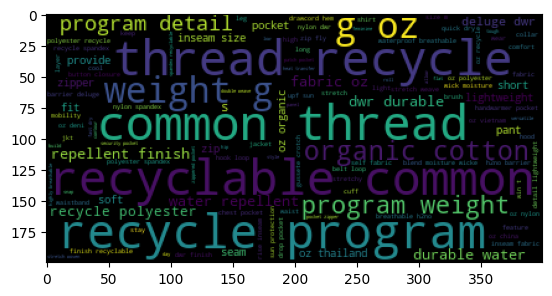

-----------
CLUSTER  1


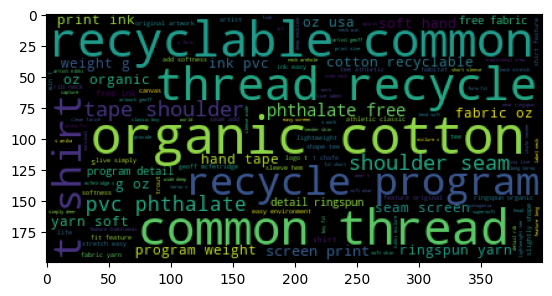

-----------
CLUSTER  2


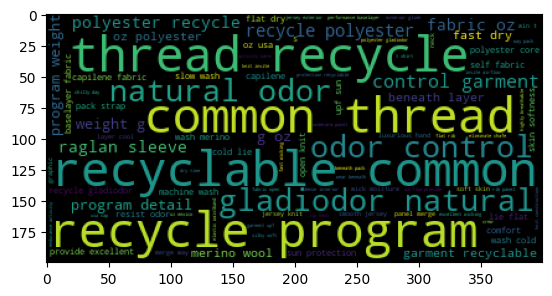

-----------
CLUSTER  7


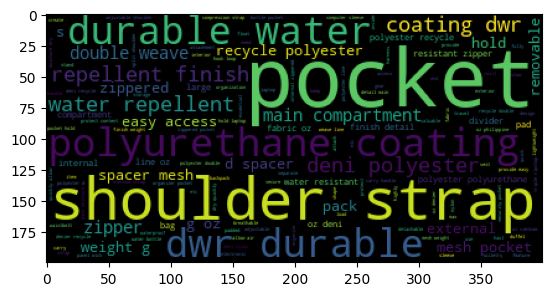

-----------
CLUSTER  5


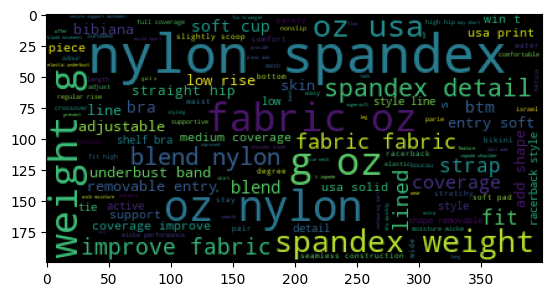

-----------
CLUSTER  9


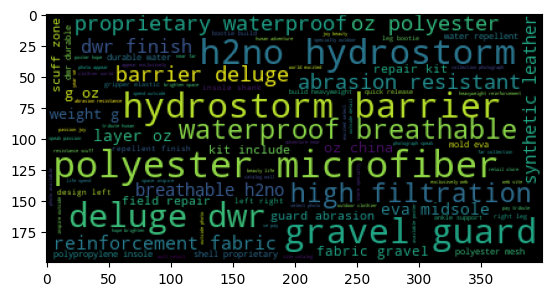

-----------
CLUSTER  8


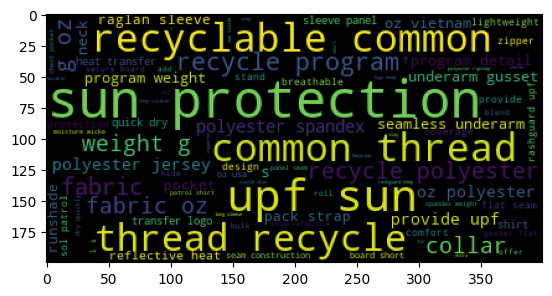

-----------
CLUSTER  3


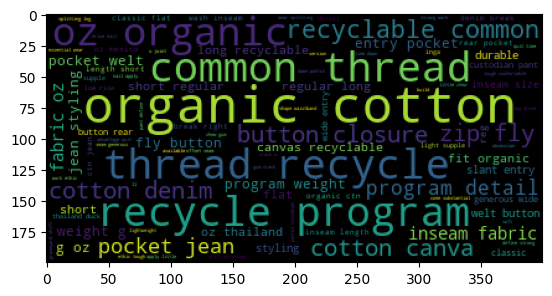

-----------
CLUSTER  4


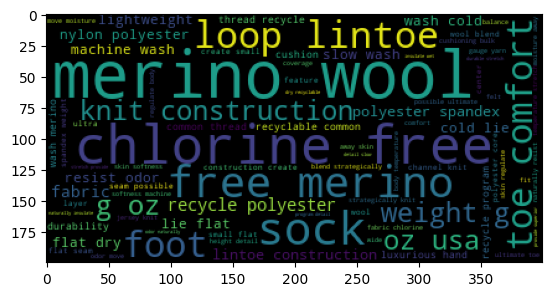

-----------
CLUSTER  6


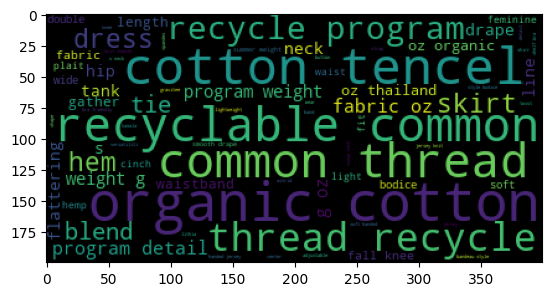

-----------


In [106]:
# visualization of a wordcloud for each class

# we first loop through the cluster labels
for c in topic_encoded_df["class_pred"].value_counts().index : # gives the unique values of the clusters sorted by their importance (number of values)
    print("CLUSTER ", c)
    texts = " ".join(topic_encoded_df.loc[topic_encoded_df["class_pred"]==c,"documents"]) # Concatenates the text documents in the current cluster into a single string named texts. It uses the "documents" column from the DataFrame
    cloud = wd.generate(texts) # Uses a word cloud generator to generate a word cloud from the concatenated text in the current cluster
    plt.imshow(cloud) # Displays the generated word cloud using Matplotlib
    plt.show() # shows the plot
    print("-----------")

In [109]:
# Create DataFrame containing the description of each topic in terms of the words in the vocabulary
# we set index's name with a list comprehension getting number of topic
# we set columns's name with the feature names obtained from the TF-IDF vectorizer (vectorizer), which likely represents the terms (words) in the original documents
# values are from the components of our model, representing the importance of each term within each topic
topics_description = pd.DataFrame(svd_model.components_,
                                  columns = vectorizer.get_feature_names_out(),
                                  index = ["topic_" + str(i) for i in range(svd_model.components_.shape[0])])

# Compute absolute values of coefficients
# indeed, in the context of Latent Semantic Analysis (LSA), the sign of the components may not carry specific meaning
# focusing on the absolute value can be more informative for interpreting the importance of terms in topics
topics_description = topics_description.apply(np.abs, axis = 1)

topics_description.head(10)

000        03        10       100      1000      1021      1027  \
topic_0  0.002540  0.000543  0.049019  0.131556  0.000400  0.000318  0.000248   
topic_1  0.000252  0.000743  0.009239  0.053766  0.000489  0.000459  0.000276   
topic_2  0.001212  0.000710  0.046279  0.016830  0.000421  0.000325  0.000134   
topic_3  0.003982  0.001399  0.085361  0.056715  0.001166  0.000673  0.000097   
topic_4  0.002264  0.000344  0.012059  0.062955  0.000381  0.000064  0.000039   
topic_5  0.002872  0.000939  0.046244  0.040925  0.000083  0.000258  0.000859   
topic_6  0.001920  0.000828  0.021274  0.048110  0.000719  0.000840  0.000091   
topic_7  0.003426  0.001740  0.004538  0.052000  0.002932  0.002699  0.000845   
topic_8  0.001959  0.000368  0.006227  0.015002  0.000990  0.000434  0.000251   
topic_9  0.005050  0.001958  0.020838  0.038890  0.003232  0.001432  0.001892   

              103      1038      1055  ...      yvon      zest    zinger  \
topic_0  0.012129  0.000423  0.000191  ...  0.001639  0.001138  0.000637   
topic_1  0.023150  0.000591  0.000274  ...  0.004780  0.001406  0.000852   
topic_2  0.000631  0.000542  0.000121  ...  0.000703  0.000266  0.000818   
topic_3  0.005875  0.001255  0.000203  ...  0.003095  0.002590  0.000847   
topic_4  0.003024  0.000242  0.000317  ...  0.000554  0.000681  0.000339   
topic_5  0.005792  0.000378  0.000888  ...  0.000816  0.002450  0.000477   
topic_6  0.006108  0.000992  0.000059  ...  0.002162  0.005400  0.000853   
topic_7  0.007823  0.004391  0.000709  ...  0.000883  0.001625  0.003201   
topic_8  0.003952  0.000825  0.000184  ...  0.001089  0.002252  0.001218   
topic_9  0.002356  0.002146  0.002267  ...  0.000948  0.003167  0.001304   

              zip    zipped    zipper  zippered   zipping      zips      zone  
topic_0  0.084749  0.000894  0.086274  0.067284  0.001780  0.001775  0.007086  
topic_1  0.058853  0.001061  0.102269  0.079123  0.002678  0.002392  0.010957  
topic_2  0.067780  0.000387  0.049354  0.060539  0.001993  0.001911  0.001495  
topic_3  0.073960  0.000983  0.119710  0.062736  0.004930  0.001190  0.017206  
topic_4  0.021782  0.000103  0.013027  0.011275  0.000593  0.000397  0.020104  
topic_5  0.063567  0.000294  0.063073  0.009055  0.003787  0.001027  0.004166  
topic_6  0.051167  0.000446  0.032565  0.052049  0.003525  0.001113  0.011462  
topic_7  0.060504  0.000995  0.001241  0.053135  0.005648  0.005802  0.025581  
topic_8  0.037996  0.000187  0.010617  0.024194  0.001107  0.000844  0.006181  
topic_9  0.064607  0.003150  0.047638  0.044873  0.002422  0.001319  0.066351  

[10 rows x 3833 columns]